In [390]:
from pandas import Series, DataFrame
import pandas as pd
%pylab inline
from patsy import dmatrices
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Read the file

In [332]:
dataset=pd.read_excel('CleanData.xlsx').drop_duplicates().dropna()
dataset=dataset.drop(['Unnamed: 0', 'Date_of_Joining'], axis=1)
dataset

,Gender,Company_Type,WFH_Setup_Available,Designation,Resource_Allocation,Mental_Fatigue_Score,Burn_Rate
0,Female,Service,No,2,3,3.8,0.16
1,Male,Service,Yes,1,2,5.0,0.36
2,Male,Service,Yes,1,1,2.6,0.20
3,Female,Service,No,3,7,6.9,0.52
4,Male,Product,Yes,2,4,3.6,0.29
...,...,...,...,...,...,...,...
18585,Female,Product,Yes,1,3,6.0,0.48
18586,Male,Product,No,3,7,6.2,0.54
18587,Female,Product,Yes,3,6,6.7,0.59
18588,Female,Service,No,2,5,5.9,0.52


# Stratified Train-Test Split

In [319]:
# Create Stratified and Test Samples
y=dataset.pop('Burn_Rate').to_frame()
X=dataset

In [365]:
# Using a 70"30 split in train:test
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,test_size=0.3,random_state=1)

In [321]:
# Checking the number of rows and columns
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((13013, 6), (13013, 1), (5577, 6), (5577, 1))

In [322]:
# Checking class imbalance in train
y_train['Burn_Rate'].value_counts()/len(y_train['Burn_Rate'])*100

0.47    2.236225
0.43    2.051794
0.45    2.036425
0.50    1.982633
0.41    1.967264
          ...   
0.98    0.092215
0.95    0.084531
0.97    0.061477
0.96    0.053792
0.99    0.046108
Name: Burn_Rate, Length: 101, dtype: float64

In [323]:
# Checking class imbalance in test
y_test['Burn_Rate'].value_counts()/len(y_test['Burn_Rate'])*100

0.47    2.241348
0.43    2.062041
0.45    2.044110
0.50    1.990317
0.41    1.954456
          ...   
0.98    0.089654
0.95    0.089654
0.97    0.053792
0.96    0.053792
0.99    0.035862
Name: Burn_Rate, Length: 101, dtype: float64

# EDA 

In [324]:
# Checking variable types
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13013 entries, 3533 to 13453
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Gender                13013 non-null  object 
 1   Company_Type          13013 non-null  object 
 2   WFH_Setup_Available   13013 non-null  object 
 3   Designation           13013 non-null  int64  
 4   Resource_Allocation   13013 non-null  int64  
 5   Mental_Fatigue_Score  13013 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 711.6+ KB


In [325]:
# Checking variable correlation statistics 
X_train.describe()

,Designation,Resource_Allocation,Mental_Fatigue_Score
count,13013.000000,13013.000000,13013.000000
mean,2.178744,4.477984,5.735488
std,1.134589,2.039966,1.919201
min,0.000000,1.000000,0.000000
25%,1.000000,3.000000,4.600000
50%,2.000000,4.000000,5.900000
75%,3.000000,6.000000,7.100000
max,5.000000,10.000000,10.000000


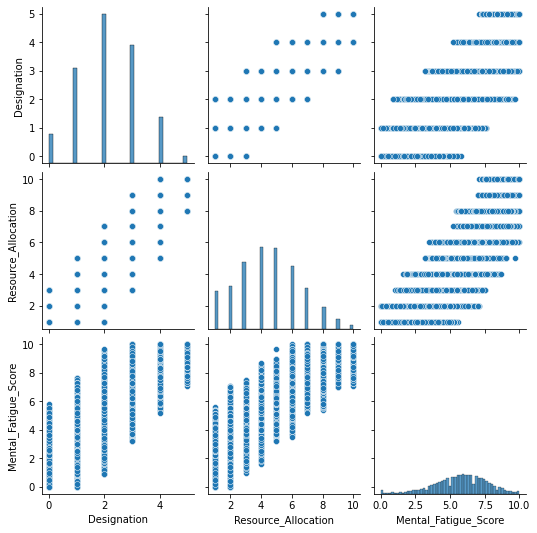

In [326]:
# Data Visualization
sns.pairplot(dataset)

# Model Fit

### 1. Multi Linear Regression

In [327]:
import statsmodels.api as sm
from patsy import dmatrices

In [328]:
dataset.columns = [c.replace(' ', '_') for c in dataset.columns]
dataset[:5]

,Gender,Company_Type,WFH_Setup_Available,Designation,Resource_Allocation,Mental_Fatigue_Score
0,Female,Service,No,2,3,3.8
1,Male,Service,Yes,1,2,5.0
2,Male,Service,Yes,1,1,2.6
3,Female,Service,No,3,7,6.9
4,Male,Product,Yes,2,4,3.6


In [329]:
dataset['WFH_Setup_Available'].replace(('Yes', 'No'), (1, 0), inplace=True)
dataset['Gender'].replace(('Female', 'Male'), (1, 0), inplace=True)
dataset[:5]

,Gender,Company_Type,WFH_Setup_Available,Designation,Resource_Allocation,Mental_Fatigue_Score
0,1,Service,0,2,3,3.8
1,0,Service,1,1,2,5.0
2,0,Service,1,1,1,2.6
3,1,Service,0,3,7,6.9
4,0,Product,1,2,4,3.6


In [334]:
# Create design matrics
y, X = dmatrices('Burn_Rate ~ Gender + WFH_Setup_Available + Designation + Resource_Allocation + Mental_Fatigue_Score',data=dataset, return_type='dataframe')

# Run the linear regression
model = sm.OLS(y, X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              Burn_Rate   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 4.313e+04
Date:                Fri, 05 Aug 2022   Prob (F-statistic):               0.00
Time:                        14:49:51   Log-Likelihood:                 27297.
No. Observations:               18590   AIC:                        -5.458e+04
Df Residuals:                   18584   BIC:                        -5.454e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [335]:
result.params #neg: gender, wfh, desg

Intercept                    -0.084858
Gender[T.Male]                0.004436
WFH_Setup_Available[T.Yes]   -0.011573
Designation                  -0.004758
Resource_Allocation           0.028603
Mental_Fatigue_Score          0.073877
dtype: float64

In [336]:
result.rsquared #Good fit, the regression explains 92% of data variability

0.9206635076855432

In [337]:
result.pvalues #the lowest p-values are WFH, designation, Gender

Intercept                     0.000000e+00
Gender[T.Male]                8.749079e-08
WFH_Setup_Available[T.Yes]    4.264910e-41
Designation                   2.944633e-10
Resource_Allocation           0.000000e+00
Mental_Fatigue_Score          0.000000e+00
dtype: float64

#### Take out variables, that don't have as big as a significant

In [338]:
y, X = dmatrices('Burn_Rate ~  WFH_Setup_Available + Resource_Allocation + Mental_Fatigue_Score',data=dataset, return_type='dataframe')

# Run the linear regression
model = sm.OLS(y, X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              Burn_Rate   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                 7.160e+04
Date:                Fri, 05 Aug 2022   Prob (F-statistic):               0.00
Time:                        14:49:55   Log-Likelihood:                 27262.
No. Observations:               18590   AIC:                        -5.452e+04
Df Residuals:                   18586   BIC:                        -5.448e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [339]:
result.params

Intercept                    -0.083529
WFH_Setup_Available[T.Yes]   -0.011919
Resource_Allocation           0.026289
Mental_Fatigue_Score          0.074049
dtype: float64

In [340]:
result.rsquared

0.9203640274092914

In [341]:
result.pvalues

Intercept                     0.000000e+00
WFH_Setup_Available[T.Yes]    2.035339e-43
Resource_Allocation           0.000000e+00
Mental_Fatigue_Score          0.000000e+00
dtype: float64

#### We can see that after taking out the two variables, Gender and Designation, there is not a a significant change in the r-sqaured.

#### The most significant variables of our dataset are WFH, Resource Allocation, and Mental Fatigue Score. 

In [342]:
X1 = X.values
y1 = y.values
print(X1)
print(y1)

[[1.  0.  3.  3.8]
 [1.  1.  2.  5. ]
 [1.  1.  1.  2.6]
 ...
 [1.  1.  6.  6.7]
 [1.  0.  5.  5.9]
 [1.  0.  6.  7.8]]
[[0.16]
 [0.36]
 [0.2 ]
 ...
 [0.59]
 [0.52]
 [0.61]]


In [367]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size = 0.2)
X_test

array([[1. , 0. , 1. , 3.1],
       [1. , 0. , 3. , 4.8],
       [1. , 0. , 2. , 2.7],
       ...,
       [1. , 1. , 5. , 9.7],
       [1. , 0. , 3. , 3.8],
       [1. , 1. , 3. , 3.1]])

In [368]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [369]:
y_pred = regressor.predict(X_test)
df = pd.DataFrame({'Real_Values':y_test.tolist(), 'Predicted_Values':y_pred.tolist()})
df['Real_Values'] = df['Real_Values'].str.get(0)
df['Predicted_Values'] = df['Predicted_Values'].str.get(0)
df

,Real_Values,Predicted_Values
0,0.11,0.172549
1,0.38,0.351140
2,0.22,0.169637
3,0.27,0.297182
4,0.56,0.578455
...,...,...
3713,0.47,0.554003
3714,0.01,-0.068736
3715,0.81,0.753171
3716,0.23,0.277374


In [370]:
def acc(index):
    absolute = mean(abs(df['Real_Values'][index] - df['Predicted_Values'][index]))
    length = len(df['Real_Values'])
    return absolute

In [372]:
total = 0 
for i in range(0, 3718):
    total += acc(i)
total/len(df['Real_Values'])

0.04496709024081808

### 2. Naive Bayes

In [223]:
# Create the target 
dataset['Target']=0.0
mask=(dataset['Burn_Rate']>0.49)
dataset['Target'][mask]=1.0
dataset['Target'].value_counts()

C:\Users\zjnbl\AppData\Local\Temp\ipykernel_12880\2799578179.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Target'][mask]=1.0


0.0    10826
1.0     7764
Name: Target, dtype: int64

In [224]:
dataset['MFS_binned'],MFS_binned=pd.qcut(dataset['Mental_Fatigue_Score'],4,retbins=True)
print(dataset['MFS_binned'][:5])

0    (-0.001, 4.6]
1       (4.6, 5.9]
2    (-0.001, 4.6]
3       (5.9, 7.1]
4    (-0.001, 4.6]
Name: MFS_binned, dtype: category
Categories (4, interval[float64, right]): [(-0.001, 4.6] < (4.6, 5.9] < (5.9, 7.1] < (7.1, 10.0]]


In [225]:
dataset['D_binned']='2'
dataset['D_binned'][dataset['Designation']<2]='<2'
dataset['D_binned'][dataset['Designation']>2]='>2'

C:\Users\zjnbl\AppData\Local\Temp\ipykernel_12880\3157525594.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['D_binned'][dataset['Designation']<2]='<2'
C:\Users\zjnbl\AppData\Local\Temp\ipykernel_12880\3157525594.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['D_binned'][dataset['Designation']>2]='>2'


In [226]:
dataset['RA_binned']='5'
dataset['RA_binned'][dataset['Resource_Allocation']<5]='<5'
dataset['RA_binned'][dataset['Resource_Allocation']>5]='>5'

C:\Users\zjnbl\AppData\Local\Temp\ipykernel_12880\184053704.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['RA_binned'][dataset['Resource_Allocation']<5]='<5'
C:\Users\zjnbl\AppData\Local\Temp\ipykernel_12880\184053704.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['RA_binned'][dataset['Resource_Allocation']>5]='>5'


In [227]:
# Make a list of all categorical variabels
categorical_columns=['Gender','Company_Type','WFH_Setup_Available','D_binned','RA_binned','MFS_binned']

# Create dummy variables
dataset_dummies=pd.get_dummies(dataset[categorical_columns],prefix=categorical_columns,columns=categorical_columns)
dummy_column_names=dataset_dummies.columns.values
dummy_column_names[:10]

array(['Gender_Female', 'Gender_Male', 'Company_Type_Product',
       'Company_Type_Service', 'WFH_Setup_Available_No',
       'WFH_Setup_Available_Yes', 'D_binned_2', 'D_binned_<2',
       'D_binned_>2', 'RA_binned_5'], dtype=object)

In [228]:
# Concatenate these new dummy columns into the old dataframe
dataset_2=pd.concat([dataset,dataset_dummies],axis=1)
dataset_2

,Gender,Company_Type,WFH_Setup_Available,Designation,Resource_Allocation,Mental_Fatigue_Score,Burn_Rate,Target,MFS_binned,D_binned,...,D_binned_2,D_binned_<2,D_binned_>2,RA_binned_5,RA_binned_<5,RA_binned_>5,"MFS_binned_(-0.001, 4.6]","MFS_binned_(4.6, 5.9]","MFS_binned_(5.9, 7.1]","MFS_binned_(7.1, 10.0]"
0,Female,Service,No,2,3,3.8,0.16,0.0,"(-0.001, 4.6]",2,...,1,0,0,0,1,0,1,0,0,0
1,Male,Service,Yes,1,2,5.0,0.36,0.0,"(4.6, 5.9]",<2,...,0,1,0,0,1,0,0,1,0,0
2,Male,Service,Yes,1,1,2.6,0.20,0.0,"(-0.001, 4.6]",<2,...,0,1,0,0,1,0,1,0,0,0
3,Female,Service,No,3,7,6.9,0.52,1.0,"(5.9, 7.1]",>2,...,0,0,1,0,0,1,0,0,1,0
4,Male,Product,Yes,2,4,3.6,0.29,0.0,"(-0.001, 4.6]",2,...,1,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18585,Female,Product,Yes,1,3,6.0,0.48,0.0,"(5.9, 7.1]",<2,...,0,1,0,0,1,0,0,0,1,0
18586,Male,Product,No,3,7,6.2,0.54,1.0,"(5.9, 7.1]",>2,...,0,0,1,0,0,1,0,0,1,0
18587,Female,Product,Yes,3,6,6.7,0.59,1.0,"(5.9, 7.1]",>2,...,0,0,1,0,0,1,0,0,1,0
18588,Female,Service,No,2,5,5.9,0.52,1.0,"(4.6, 5.9]",2,...,1,0,0,1,0,0,0,1,0,0


In [229]:
formula='Target~0+{}'.format('+'.join(['Q("{}")'.format(x)\
                                       for x in dummy_column_names]))
print(formula)

Target~0+Q("Gender_Female")+Q("Gender_Male")+Q("Company_Type_Product")+Q("Company_Type_Service")+Q("WFH_Setup_Available_No")+Q("WFH_Setup_Available_Yes")+Q("D_binned_2")+Q("D_binned_<2")+Q("D_binned_>2")+Q("RA_binned_5")+Q("RA_binned_<5")+Q("RA_binned_>5")+Q("MFS_binned_(-0.001, 4.6]")+Q("MFS_binned_(4.6, 5.9]")+Q("MFS_binned_(5.9, 7.1]")+Q("MFS_binned_(7.1, 10.0]")


In [230]:
Y,X=dmatrices(formula,dataset_2,return_type='dataframe')
y=Y['Target'].values

In [231]:
# Set up the classifier
from sklearn import naive_bayes
model=naive_bayes.MultinomialNB()

# Fit the model
model.fit(X,y)

MultinomialNB()

In [232]:
# Test on some training data
print('Prediction')
print(model.predict(X[:10]))
print('Actual')
print(y[:10])

Prediction
[0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
Actual
[0. 0. 0. 1. 0. 1. 0. 1. 0. 1.]


In [233]:
from sklearn import metrics

prediction_train=model.predict(X)
print(metrics.accuracy_score(y,prediction_train))

0.9033889187735341


### 3. KNN

In [234]:
dataset_3=dataset[['Mental_Fatigue_Score','Resource_Allocation','Burn_Rate']].copy()
dataset_3

,Mental_Fatigue_Score,Resource_Allocation,Burn_Rate
0,3.8,3,0.16
1,5.0,2,0.36
2,2.6,1,0.20
3,6.9,7,0.52
4,3.6,4,0.29
...,...,...,...
18585,6.0,3,0.48
18586,6.2,7,0.54
18587,6.7,6,0.59
18588,5.9,5,0.52


In [235]:
# Total datapoints
len(dataset_3)

18590

In [236]:
dataset_3['Burn_Rate'].value_counts()

0.47    416
0.43    382
0.45    379
0.50    369
0.41    365
       ... 
0.98     17
0.95     16
0.97     11
0.96     10
0.99      8
Name: Burn_Rate, Length: 101, dtype: int64

In [237]:
# Create a new 'target' column with all o
dataset_3['target']=0.0
mask=(dataset_3['Burn_Rate']>0.49)
dataset_3.loc[mask,'target']=1.0
dataset_3

,Mental_Fatigue_Score,Resource_Allocation,Burn_Rate,target
0,3.8,3,0.16,0.0
1,5.0,2,0.36,0.0
2,2.6,1,0.20,0.0
3,6.9,7,0.52,1.0
4,3.6,4,0.29,0.0
...,...,...,...,...
18585,6.0,3,0.48,0.0
18586,6.2,7,0.54,1.0
18587,6.7,6,0.59,1.0
18588,5.9,5,0.52,1.0


In [238]:
Y,X=dmatrices('target~0 + Mental_Fatigue_Score+Resource_Allocation',dataset_3,return_type='dataframe')
print('Design matrix X')
print(X[:5])
print('Outcomes Y')
print(Y[:5])

Design matrix X
   Mental_Fatigue_Score  Resource_Allocation
0                   3.8                  3.0
1                   5.0                  2.0
2                   2.6                  1.0
3                   6.9                  7.0
4                   3.6                  4.0
Outcomes Y
   target
0     0.0
1     0.0
2     0.0
3     1.0
4     0.0


In [239]:
y=Y['target'].values
print(y[:5])

[0. 0. 0. 1. 0.]


Text(0, 0.5, 'Resource Allocation')

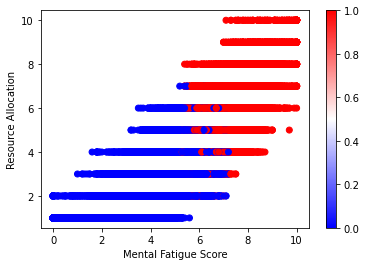

In [240]:
# Plot the data 
sc=plt.scatter(dataset_3['Mental_Fatigue_Score'],dataset_3['Resource_Allocation'],c=e,cmap='bwr')
plt.colorbar(sc)
plt.xlabel('Mental Fatigue Score')
plt.ylabel('Resource Allocation')

In [256]:
y_train[:5]

array([1., 1., 1., 0., 0.])

In [257]:
# Set up the classifier
from sklearn import neighbors
model=neighbors.KNeighborsClassifier(n_neighbors=15,weights='uniform',p=2)

# Fit the classifier
model.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=15)

In [258]:
print('Predictions=',model.predict(X_train.iloc[0:5]))

Predictions= [1. 1. 1. 0. 0.]


In [259]:
from sklearn import metrics
prediction_on_training=model.predict(X_train)
print(metrics.accuracy_score(y_train,prediction_on_training))

0.9188503803888419
